In [396]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pyro
import pyro.distributions as dist
from pyro import infer, poutine
from pyro.infer import Importance, EmpiricalMarginal, SMCFilter
from pyro.nn.module import PyroParam, PyroModule, PyroSample
from pyro.contrib.gp import Parameterized
import pyro.contrib.gp as gp
plt.style.use("seaborn-v0_8")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [343]:
pyro.set_rng_seed(0)
N = 50
x = torch.empty(N,).uniform_(-1, 1)
x = x.sort().values.unsqueeze(1)
w = torch.randn(1)
b = torch.tensor(0.5)
y = w * x + b

In [344]:
class Linear(Parameterized):
    
    def __init__(self, in_features, out_features):
        super().__init__()
        self.w = torch.nn.Parameter(torch.zeros(in_features, out_features).uniform_(-1., 1.))
        self.b = torch.nn.Parameter(torch.zeros(out_features).uniform_(-1., 1.))

    def forward(self, x):
        return  (x @ self.w + self.b)


In [345]:
linear = Linear(1, 1)

In [346]:
linear.w, linear.b

(Parameter containing:
 tensor([[0.6705]], requires_grad=True),
 Parameter containing:
 tensor([-0.5888], requires_grad=True))

In [347]:
linear.parameters()

<generator object Module.parameters at 0x7f24c2e105f0>

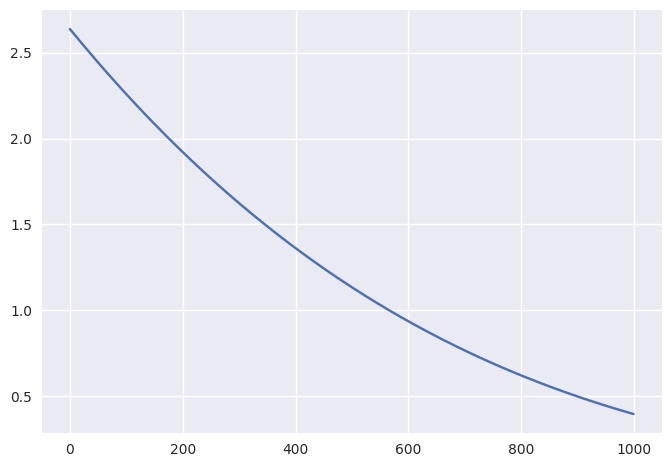

In [348]:
model = Linear(1, 1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()
losses = []
for i in range(1000):
    loss = criterion(model(x), y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    
plt.plot(losses)

In [349]:
model = Linear(1, 1)

In [350]:
model.w = PyroSample(dist.Normal(0, 1).expand([1, 1]))

In [351]:
model.w 

tensor([[0.5186]])

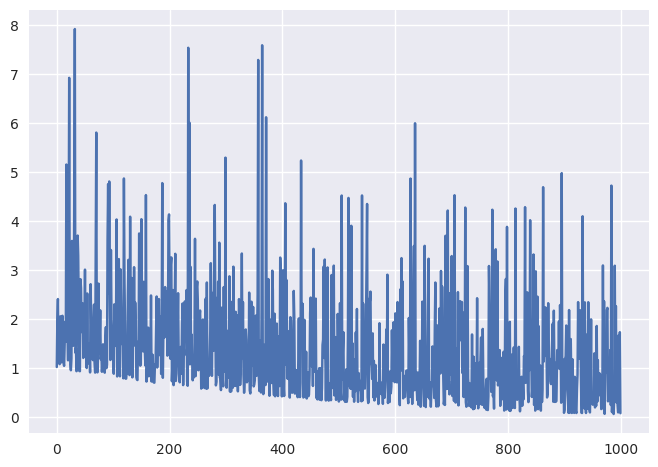

In [352]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()
losses = []
for i in range(1000):
    loss = criterion(model(x), y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    
plt.plot(losses)


In [353]:
model.w 

tensor([[-0.3045]])

In [354]:
model = Linear(1, 1)
model.w = PyroSample(lambda model: dist.Normal(0, 1).expand([1, 1]))

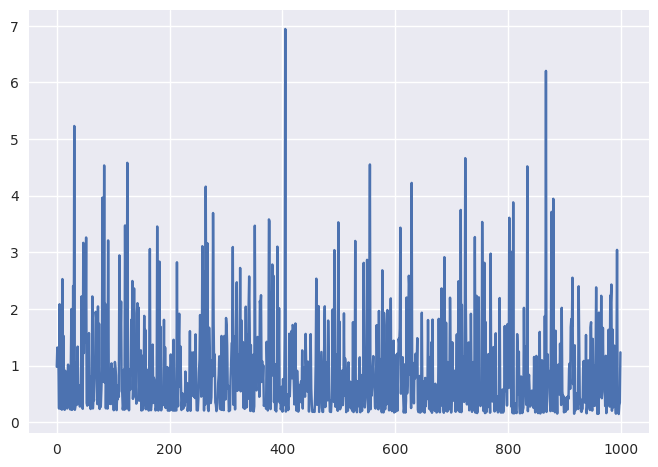

In [355]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.MSELoss()
losses = []
for i in range(1000):
    loss = criterion(model(x), y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    
plt.plot(losses)

In [356]:
class Linear(Parameterized):
    
    def __init__(self, in_features, out_features):
        super().__init__()
        self.w = torch.nn.Parameter(torch.zeros(in_features, out_features).uniform_(-1., 1.))
        self.b = PyroParam(torch.ones(out_features),
                           constraint=dist.constraints.positive
                            )
    def forward(self, x):
        return  (x @ self.w + self.b)

def model_fn(x, model: Linear, y):
    model.set_mode("model")
    mu = model(x)
    with pyro.plate("data", N):
        return pyro.sample("obs", dist.Normal(mu, 0.1).to_event(1), obs=y)

def guide_fn(x, model, y):
    model.set_mode("guide")
    model._load_pyro_samples()    

In [357]:
model = Linear(1, 1)

In [358]:
model.w

Parameter containing:
tensor([[-0.5295]], requires_grad=True)

In [359]:
model.b

tensor([1.], grad_fn=<AddBackward0>)

In [360]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.5295]], requires_grad=True),
 Parameter containing:
 tensor([0.], requires_grad=True)]

In [361]:
model.w = PyroSample(dist.Normal(0., 1.).expand(model.w.size()).to_event(2))

In [362]:
model.autoguide("w", dist.Normal)

In [363]:
list(model.parameters())

[Parameter containing:
 tensor([0.], requires_grad=True),
 Parameter containing:
 tensor([[0.0420]], requires_grad=True),
 Parameter containing:
 tensor([[0.]], requires_grad=True)]

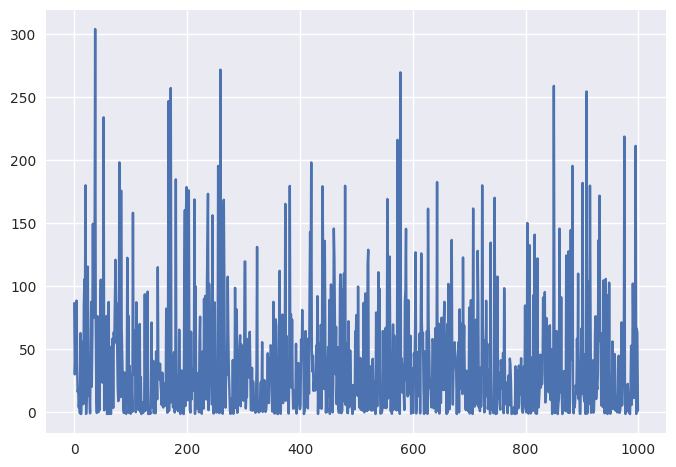

In [364]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = infer.Trace_ELBO().differentiable_loss
losses = []
for i in range(1000):
    loss = loss_fn(model_fn, guide_fn, x, model, y) / N
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    
plt.plot(losses)

In [365]:
list(model.parameters())

[Parameter containing:
 tensor([-0.6930], requires_grad=True),
 Parameter containing:
 tensor([[-0.0330]], requires_grad=True),
 Parameter containing:
 tensor([[-0.0436]], requires_grad=True)]

In [366]:
class Linear(Parameterized):
    
    def __init__(self, in_features, out_features):
        super().__init__()
        self.w = PyroSample(dist.Normal(torch.zeros(in_features, out_features).uniform_(-1., 1.), 1.0).to_event(2))
        self.b = PyroParam(torch.ones(out_features),
                           constraint=dist.constraints.positive
                            )
    def forward(self, x):
        return  (x @ self.w + self.b)

def model_fn(x, model: Linear, y):
    model.set_mode("model")
    mu = model(x)
    with pyro.plate("data", N):
        return pyro.sample("obs", dist.Normal(mu, 0.1).to_event(1), obs=y)

def guide_fn(x, model, y):
    model.set_mode("guide")
    model._load_pyro_samples()    

In [367]:
pyro.clear_param_store()
model = Linear(1, 1)

In [368]:
for n in model.named_parameters():
    print(n )

('w_map', Parameter containing:
tensor([[-0.3282]], requires_grad=True))
('b_unconstrained', Parameter containing:
tensor([0.], requires_grad=True))


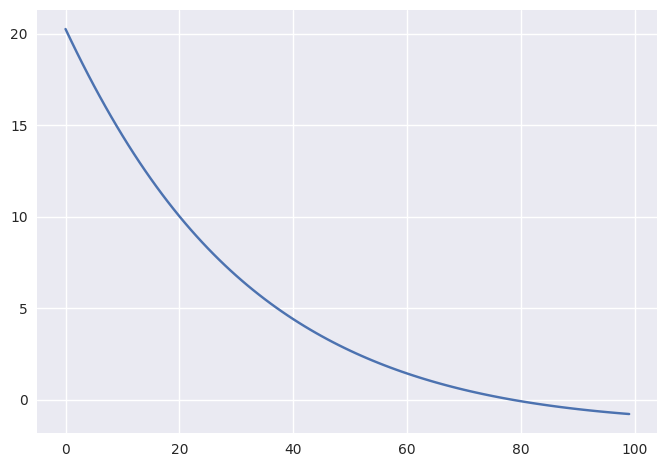

In [370]:

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
loss_fn = infer.Trace_ELBO().differentiable_loss
losses = []
for i in range(100):
    loss = loss_fn(model_fn, guide_fn, x, model, y) / N
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    
plt.plot(losses)

In [371]:
for n in model.named_parameters():
    print(n )

('w_map', Parameter containing:
tensor([[-1.0845]], requires_grad=True))
('b_unconstrained', Parameter containing:
tensor([-0.5694], requires_grad=True))


In [372]:
model.set_mode("guide")

In [373]:
for n in model.named_parameters():
    print(n )

('w_map', Parameter containing:
tensor([[-1.0845]], requires_grad=True))
('b_unconstrained', Parameter containing:
tensor([-0.5694], requires_grad=True))


In [374]:
model.w

tensor([[-1.0845]], grad_fn=<ExpandBackward0>)

In [375]:
model.w

tensor([[-1.0845]], grad_fn=<ExpandBackward0>)

In [376]:
model.set_mode("model")

In [377]:
model.w

tensor([[0.3788]])

In [378]:
model.w

tensor([[2.8969]])

In [379]:
list(model.modules())

[Linear()]

In [380]:
model.set_mode("guide")

In [383]:
list(model.modules())[0]

Linear()

In [385]:
type(list(model.modules())[0])

__main__.Linear

In [387]:
for m in model.modules():
    print(m)

Linear()


In [389]:
for mm in m.modules():
    print(mm)

Linear()


In [390]:
m == mm

True

In [391]:
m.w

tensor([[-1.0845]], grad_fn=<ExpandBackward0>)

In [392]:
m.b

tensor([0.5659], grad_fn=<AddBackward0>)

In [394]:
list(m.named_parameters())

[('w_map',
  Parameter containing:
  tensor([[-1.0845]], requires_grad=True)),
 ('b_unconstrained',
  Parameter containing:
  tensor([-0.5694], requires_grad=True))]

In [395]:
list(m.children())

[]